In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#plt.style.use('ggplot')

# 1. Combined Cycle Power Plant Data Set

## 1.(a) Download the combined Combined Cycle Power Plant data

In [2]:
data_path = "../data/CCPP/Folds5x2_pp.xlsx"
ccpp = pd.read_excel(data_path);

## 1.(b) Explore the Data

In [3]:
# 1.(b)i explore the shape of dataset and the meaning of data 
ccpp

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90
...,...,...,...,...,...
9563,16.65,49.69,1014.01,91.00,460.03
9564,13.19,39.18,1023.67,66.78,469.62
9565,31.32,74.33,1012.92,36.48,429.57
9566,24.48,69.45,1013.86,62.39,435.74


There are 9568 rows in the dataset and 5 columns. Each row represent a sample point. For the columns, there four features consist of hourly average ambient variables Temperature (AT), Ambient Pressure (AP), Relative Humidity (RH) and Exhaust Vacuum (V) while the column of PE is the net hourly electrical energy output of the plant, which is the value we want to predict based on feature.

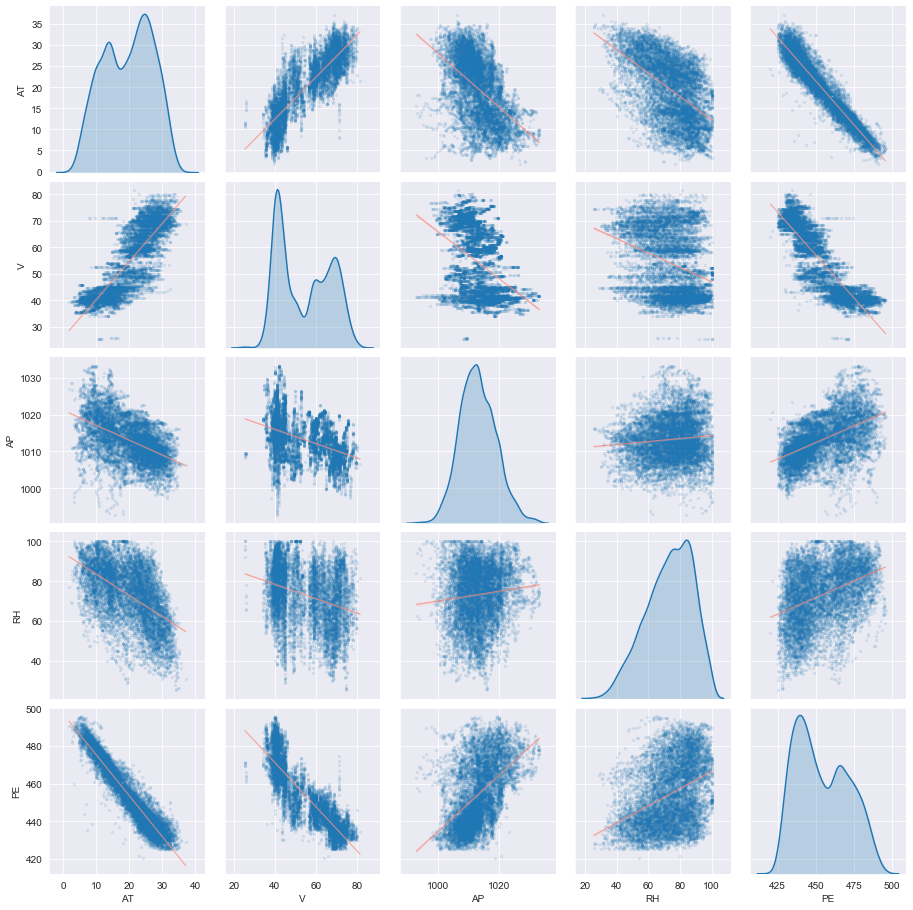

In [4]:
# 1.(b)ii Make scatterplots
sns.set_style("darkgrid")
pair_plot = sns.pairplot(ccpp, diag_kind="kde", kind="reg", 
                         palette=sns.color_palette("Paired"),
                         plot_kws={'line_kws':{'color': 'salmon', "linewidth": 1, 'alpha': 0.7}, 
                                   'scatter_kws': {'s': 5, 'alpha': 0.1}})

plt.show()

> By plotting pairwise scatter plot, we can see that AT and V has a positive correlation.
>
> Besides, AT and V are very likely to have negative correlation with response PE. 

In [5]:
# 1.(b)iii Find the mean, the median, range, first and third quartiles, 
# and interquartile ranges of each of the variables in the dataset

feature = [col for col in ccpp.columns]
mean = [np.around(ccpp[col].mean(), 2) for col in ccpp.columns]
median = [np.around(ccpp[col].median(), 2) for col in ccpp.columns]
range_ = [np.around(ccpp[col].max() - ccpp[col].min(), 2) for col in ccpp.columns]
firstQ = [np.around(ccpp[col].quantile(0.25), 2) for col in ccpp.columns]
thirdQ = [np.around(ccpp[col].quantile(0.75), 2) for col in ccpp.columns]
IQR = [np.around(y - x, 2) for x, y in zip(firstQ, thirdQ)]

data_summary = {
    "feature" : feature,
    "mean" : mean,
    "median" : median,
    "range" : range_,
    "first quartile" : firstQ,
    "third quartile" : thirdQ,
    "interquartile range" : IQR
}

data_summary = pd.DataFrame(data_summary)
data_summary.set_index("feature")
data_summary

,feature,mean,median,range,first quartile,third quartile,interquartile range
0,AT,19.65,20.34,35.30,13.51,25.72,12.21
1,V,54.31,52.08,56.20,41.74,66.54,24.80
2,AP,1013.26,1012.94,40.41,1009.10,1017.26,8.16
3,RH,73.31,74.97,74.60,63.33,84.83,21.50
4,PE,454.37,451.55,75.50,439.75,468.43,28.68


### 1.(c) For each predictor, fit a simple linear regression model to predict the response.

In [6]:
# import necessary package
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf

# split columns of dataset to separate numpy arrays
trainX_AT = ccpp['AT'].to_numpy()
trainX_V = ccpp['V'].to_numpy()
trainX_AP = ccpp['AP'].to_numpy()
trainX_RH = ccpp['RH'].to_numpy()
trainY_PE = ccpp['PE'].to_numpy()

In [7]:
P_THRESH = 0.05

simple_regression_coefs = {}

# function to perform simple linear regression for each predictor
def simpleLinearRegression(trainX_feature, trainY, feature_name):
    # Note to add constant here to enable bias, use this to predict as well
    trainX = sm.add_constant(trainX_feature, prepend=False)
    
    # build model and fit the data
    olsmod = sm.OLS(trainY, trainX)
    olsres = olsmod.fit()
    
    # record the codffieients for the model and output the summary of model
    simple_regression_coefs[feature_name] = olsres.params
    print(olsres.summary())
    
    # find the outliers if exist
    outliers = olsres.outlier_test()
    outliers_idx = np.where(outliers[:, 2] < P_THRESH)
    
    # plot regression graph with outliers marked
    fig, axes = plt.subplots(figsize=(12, 7))
    with plt.style.context('ggplot'):
        axes.scatter(trainX_feature, trainY, alpha=0.3, label="Data point")
        axes.scatter(trainX_feature[outliers_idx], trainY[outliers_idx], marker="+", label="Outliers")
        axes.plot(trainX_feature, olsres.predict(trainX), "tab:red", alpha=0.8, label="Rgression Result")
    axes.set_title("Simple Linear Regression for {}".format(feature_name))
    axes.set_xlabel(feature_name)
    axes.set_ylabel("PE")
    axes.legend()
    plt.show()
    
    # output outliers as table
    outliers_tuple = np.vstack((trainX_feature[outliers_idx], trainY[outliers_idx]))
    return pd.DataFrame(outliers_tuple.T, columns=[feature_name, "PE"])

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                 8.510e+04
Date:                Fri, 25 Sep 2020   Prob (F-statistic):               0.00
Time:                        15:53:26   Log-Likelihood:                -29756.
No. Observations:                9568   AIC:                         5.952e+04
Df Residuals:                    9566   BIC:                         5.953e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -2.1713      0.007   -291.715      0.0

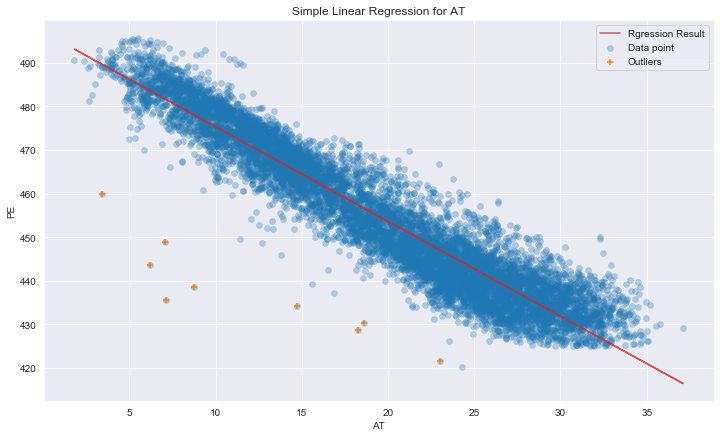

,AT,PE
0,8.74,438.63
1,6.22,443.73
2,14.69,434.12
3,23.00,421.57
4,18.60,430.38
5,7.06,448.97
6,7.14,435.58
7,18.26,428.67
8,3.40,459.86


In [8]:
outliers = simpleLinearRegression(trainX_AT, trainY_PE, "AT")
outliers

There are 9 outliers detected.

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                 2.972e+04
Date:                Fri, 25 Sep 2020   Prob (F-statistic):               0.00
Time:                        15:53:43   Log-Likelihood:                -33963.
No. Observations:                9568   AIC:                         6.793e+04
Df Residuals:                    9566   BIC:                         6.794e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -1.1681      0.007   -172.402      0.0

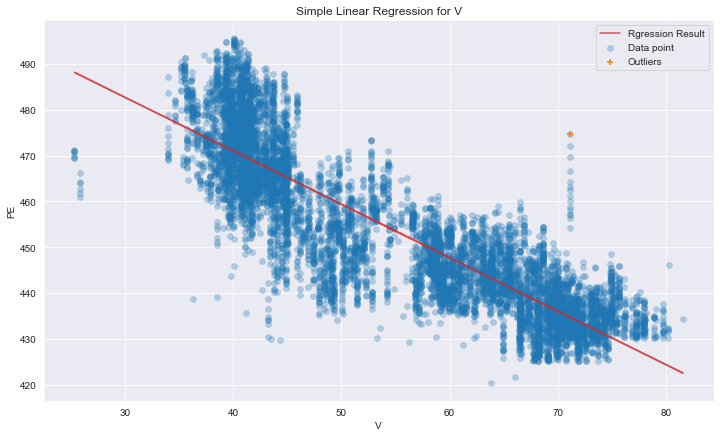

,V,PE
0,71.14,474.66


In [9]:
outliers = simpleLinearRegression(trainX_V, trainY_PE, "V")
outliers

One outlier detected here. 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.269
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     3516.
Date:                Fri, 25 Sep 2020   Prob (F-statistic):               0.00
Time:                        15:53:55   Log-Likelihood:                -39224.
No. Observations:                9568   AIC:                         7.845e+04
Df Residuals:                    9566   BIC:                         7.847e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.4899      0.025     59.296      0.0

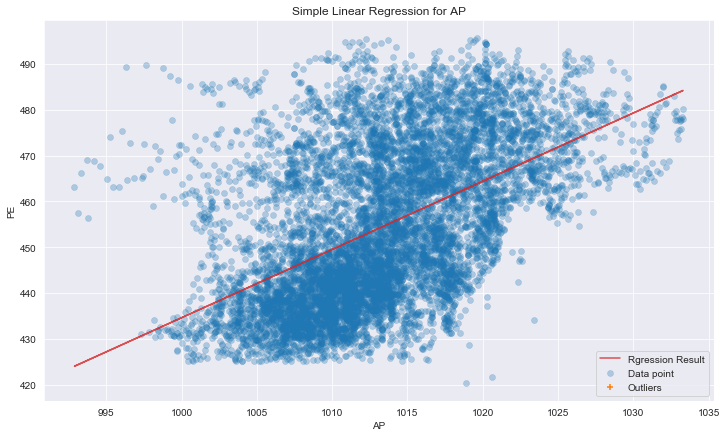

,AP,PE


In [10]:
outliers = simpleLinearRegression(trainX_AP, trainY_PE, "AP")
outliers

No outlier detected!

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     1714.
Date:                Fri, 25 Sep 2020   Prob (F-statistic):               0.00
Time:                        15:54:58   Log-Likelihood:                -39933.
No. Observations:                9568   AIC:                         7.987e+04
Df Residuals:                    9566   BIC:                         7.988e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.4557      0.011     41.399      0.0

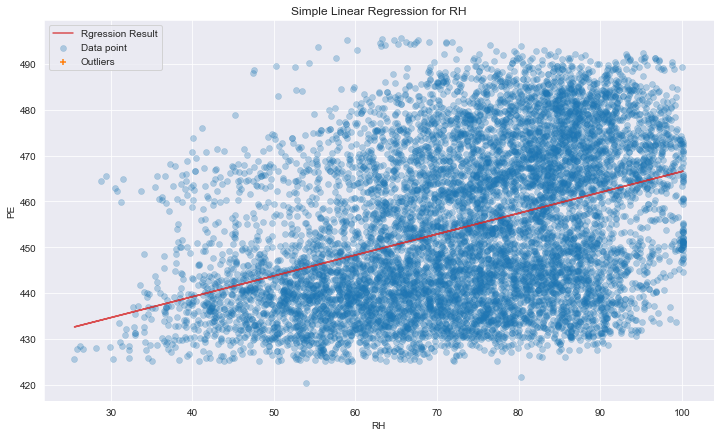

,RH,PE


In [11]:
outliers = simpleLinearRegression(trainX_RH, trainY_PE, "RH")
outliers

No outlier detected!

## 1.(d) Fit multiple regression model

In [12]:
trainX_all = ccpp.iloc[:, :-1].to_numpy()
trainX_all = sm.add_constant(trainX_all, prepend=False)

olsmod = sm.OLS(trainY_PE, trainX_all)
olsres = olsmod.fit()

print(olsres.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                 3.114e+04
Date:                Fri, 25 Sep 2020   Prob (F-statistic):               0.00
Time:                        15:55:20   Log-Likelihood:                -28088.
No. Observations:                9568   AIC:                         5.619e+04
Df Residuals:                    9563   BIC:                         5.622e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -1.9775      0.015   -129.342      0.0

Since we have p values of 0 for all predictor, we can reject all the null hypothesis $H_{0}$ : $\beta_j = 0$.

## 1.(e) Compare coefficients

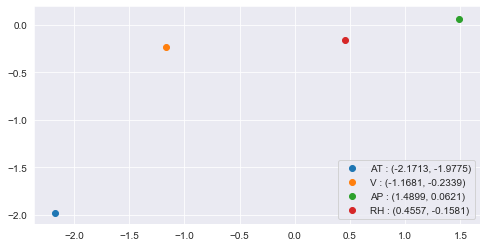

In [13]:
fig, axes = plt.subplots(figsize=(8, 4))
for i, feature in enumerate(ccpp.columns[:-1]):
    text = "{} : ({}, {})".format(feature, 
                                        np.around(simple_regression_coefs[feature][0], 4), 
                                        np.around(olsres.params[i], 4))
    axes.scatter(simple_regression_coefs[feature][0], olsres.params[i], label=text)
axes.legend()
plt.show()

## 1.(f) Any nonlinear association between any predictor and the response?

In [14]:
from sklearn.preprocessing import PolynomialFeatures

def usePolyFeature(trainX_feature, trainY, feature_name):
    # generate poly data for the given feature
    poly = PolynomialFeatures(3)
    trainX_poly = poly.fit_transform(np.expand_dims(trainX_feature, axis=1)) 
    
    # build model and fit the data
    olsmod = sm.OLS(trainY, trainX_poly)
    olsres = olsmod.fit()
    
    # output the summary of model
    print(olsres.summary())
    
    return pd.DataFrame(np.expand_dims(olsres.params, axis=0), columns=["beta_0", "beta_1", "beta_2", "beta_3"])

In [15]:
coefs = usePolyFeature(trainX_AT, trainY_PE, "AT")

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                 3.299e+04
Date:                Fri, 25 Sep 2020   Prob (F-statistic):               0.00
Time:                        15:56:09   Log-Likelihood:                -29101.
No. Observations:                9568   AIC:                         5.821e+04
Df Residuals:                    9564   BIC:                         5.824e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        492.7281      0.673    732.248      0.0

> The p-values are samll enough to reject the Null Hypothesis. That implies an evidence between those nonlinear association of predictor and respose.

In [16]:
coefs = usePolyFeature(trainX_V, trainY_PE, "V")

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                 1.098e+04
Date:                Fri, 25 Sep 2020   Prob (F-statistic):               0.00
Time:                        15:56:15   Log-Likelihood:                -33585.
No. Observations:                9568   AIC:                         6.718e+04
Df Residuals:                    9564   BIC:                         6.721e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        554.1468      9.151     60.557      0.0

> Here we can see $X^2$ and $X^3$ have relatively large p-values especailly $X^2$. That means we don't have enough conficence to reject the Null Hypothesis of $X^2$. By varying the threshold of p-value to a strict cretiria, 0.01, the $X^3$ can be treated as no association as well. 

In [18]:
coefs = usePolyFeature(trainX_AP, trainY_PE, "AP")

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     1813.
Date:                Fri, 25 Sep 2020   Prob (F-statistic):               0.00
Time:                        15:56:42   Log-Likelihood:                -39184.
No. Observations:                9568   AIC:                         7.837e+04
Df Residuals:                    9565   BIC:                         7.840e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0747      0.009      8.415      0.0

> The p-values are samll enough to reject the Null Hypothesis. That implies an evidence between those nonlinear association of predictor and respose.

In [19]:
coefs = usePolyFeature(trainX_RH, trainY_PE, "RH")

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     579.2
Date:                Fri, 25 Sep 2020   Prob (F-statistic):               0.00
Time:                        15:56:44   Log-Likelihood:                -39923.
No. Observations:                9568   AIC:                         7.985e+04
Df Residuals:                    9564   BIC:                         7.988e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        468.4135     10.545     44.422      0.0

> The p-values are samll enough to reject the Null Hypothesis. That implies an evidence between those nonlinear association of predictor and respose.

## 1.(g) Is there evidence of association of interactions of predictors with the response? 

In [20]:
piarwise_inter = 'PE ~ AT + V + AP + RH + AT*V + AT*AP + AT*RH + V*AP + V*RH + AP*RH'
olsmod = smf.ols(formula = piarwise_inter, data = ccpp)
olsres = olsmod.fit()
print(olsres.summary())

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                 1.405e+04
Date:                Fri, 25 Sep 2020   Prob (F-statistic):               0.00
Time:                        15:56:52   Log-Likelihood:                -27548.
No. Observations:                9568   AIC:                         5.512e+04
Df Residuals:                    9557   BIC:                         5.520e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    685.7825     78.640      8.721      0.0

> Statistical Significance:
> - It can be seen that $V$, $(AT:V)$, $(AT:RH)$ and $(V:AP)$ are statistically significant with their p-values are significantly smaller than 0.05. 
>
> - If we set a p-value thresh of 0.05, $AP$, $RH$ and $(AP:RH)$ can be considered as statistically significant as well. 
>
> - If we set a p-value thresh of 0.10, $AT$ and $(V:RH)$ can be considered as statistically significant as well. 
>
> - For $AT:AP$, however, it has an extremely large p-value. That implies it can never be statistically significant. 


## 1.(h) Improve your model using possible interaction terms or nonlinear asso- ciations between the predictors and response

In [21]:
import random
from sklearn.metrics import mean_squared_error

# generate indecies in random order to shuffle data
idx = [x for x in range(0,9568)]
random.seed(9568)
random.shuffle(idx)

# split the dataset: 70% train, 30% test
train_size = round(len(ccpp) * 0.7)
train_data_70 = ccpp.iloc[idx[:train_size], :]
test_X_30 = ccpp.iloc[idx[train_size:], :-1]
test_Y_30 = ccpp.iloc[idx[train_size:], -1]

# declare a dict to record MSE for different models
mse_dict = {}

**What should be emphasized here is that I fixed the random seed for dataset separation. After experiences for many times, it is discovered that the fitting is quite variant using different training set. Thus, in convenience of summarization, the random seed is fixed here. The data is randomly selected from original datset but will be a fixed group for different experiments.**

In [22]:
# model with all predictor
formula = 'PE ~ AT + V + AP + RH'
olsres = smf.ols(formula, train_data_70).fit()
print(olsres.summary())

predict_trainY = olsres.predict(train_data_70.iloc[:, :-1])
predict_testY = olsres.predict(test_X_30)

train_mse = mean_squared_error(train_data_70.iloc[:, -1], predict_trainY)
test_mse = mean_squared_error(test_Y_30, predict_testY)

mse_dict["all_predictor_LR"] = [train_mse, test_mse]

print("\nFor formula: \n {} \nwe have train MSE of {} and test MSE of {}".format(formula, np.around(train_mse, 2), np.around(test_mse, 2)))

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                 2.168e+04
Date:                Fri, 25 Sep 2020   Prob (F-statistic):               0.00
Time:                        15:57:06   Log-Likelihood:                -19623.
No. Observations:                6698   AIC:                         3.926e+04
Df Residuals:                    6693   BIC:                         3.929e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    446.0206     11.661     38.250      0.0

In [23]:
# model with all predictor, interaction and quadratic terms
formula = 'PE ~ AT + V + AP + RH + np.power(AT,2) + np.power(V,2) + np.power(AP,2) + np.power(RH,2) + AT*V + AT*AP + AT*RH + V*AP + V*RH + AP*RH'
olsres = smf.ols(formula, train_data_70).fit()
print(olsres.summary())

predict_trainy = olsres.predict(train_data_70.iloc[:, :-1])
predict_testy = olsres.predict(test_X_30)

train_mse = mean_squared_error(train_data_70.iloc[:, -1], predict_trainy)
test_mse = mean_squared_error(test_Y_30, predict_testy)

mse_dict["all_inter_LR"] = [train_mse, test_mse]

print("\nFor formula: \n {} \nwe have train MSE of {} and test MSE of {}".format(formula, np.around(train_mse, 2), np.around(test_mse, 2)))

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     7173.
Date:                Fri, 25 Sep 2020   Prob (F-statistic):               0.00
Time:                        15:57:10   Log-Likelihood:                -19160.
No. Observations:                6698   AIC:                         3.835e+04
Df Residuals:                    6683   BIC:                         3.845e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -6396.5247   1454.668     

> Based on the regression result above, we cannot reject the Null Hypothesis of $AT$, $V$, $V^2$, $AT:AP$, $V:AP$ and $V:RH$. Thus, we will only remove the 2-order terms. Although $AT$ and $V$ have large p-value as well, removing basic predictors will violate the hierachical priciple when the $AT:V$ is included.

> **P.S.** Note that, as the data is shuffled before splited into training and test sets, the result will possibly vary when re-running the script if we donnot fix the random seed. My observation is that $AT$ sometime has large p-value while sometimes not. 

In [24]:
# model after manually remove terms
formula = 'PE ~ AT + V + AP + RH + np.power(AT,2) + np.power(AP,2) + np.power(RH,2) + AT*V + AT*RH + AP*RH'
olsres = smf.ols(formula, train_data_70).fit()
print(olsres.summary())

predict_trainy = olsres.predict(train_data_70.iloc[:, :-1])
predict_testy = olsres.predict(test_X_30)

train_mse = mean_squared_error(train_data_70.iloc[:, -1], predict_trainy)
test_mse = mean_squared_error(test_Y_30, predict_testy)

#mse_dict["manual_tail_LR"] = [train_mse, test_mse]

print("\nFor formula: \n {} \nwe have train MSE of {} and test MSE of {}".format(formula, np.around(train_mse, 2), np.around(test_mse, 2)))

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                 1.001e+04
Date:                Fri, 25 Sep 2020   Prob (F-statistic):               0.00
Time:                        15:57:42   Log-Likelihood:                -19170.
No. Observations:                6698   AIC:                         3.836e+04
Df Residuals:                    6687   BIC:                         3.844e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -1.025e+04   1096.773     

In [25]:
# define a backward selection process for the improved model
def backwardSelection(train_data, formula, p_thresh):
    import re
    while True:
        olsres = smf.ols(formula, train_data).fit()
        response = re.split(" ~ ", formula)[0]
        # observe the p values excluding intersection
        p_values = olsres.pvalues[1:]
        max_p = p_values.max()
        if (max_p >= p_thresh):
            print("Remove " + p_values[p_values == max_p].axes[0].tolist()[0])
            new_terms = p_values[p_values != max_p].axes[0].tolist()
            formula = response + " ~ " + " + ".join(new_terms)
        else:
            return olsres, formula

In [26]:
# model after backwrad selection
formula = 'PE ~ AT + V + AP + RH + np.power(AT,2) + np.power(V,2) + np.power(AP,2) + np.power(RH,2) + AT*V + AT*AP + AT*RH + V*AP + V*RH + AP*RH'
olsres, tailed_formula = backwardSelection(train_data_70, formula, 0.05)
print(olsres.summary())

predict_trainy = olsres.predict(train_data_70.iloc[:, :-1])
predict_testy = olsres.predict(test_X_30)

train_mse = mean_squared_error(train_data_70.iloc[:, -1], predict_trainy)
test_mse = mean_squared_error(test_Y_30, predict_testy)

mse_dict["improved_LR"] = [train_mse, test_mse]

print("\nFor formula: \n {} \nwe have train MSE of {} and test MSE of {}".format(tailed_formula, np.around(train_mse, 2), np.around(test_mse, 2)))

Remove V:RH
Remove V:AP
Remove np.power(V, 2)
                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     9130.
Date:                Fri, 25 Sep 2020   Prob (F-statistic):               0.00
Time:                        15:57:49   Log-Likelihood:                -19161.
No. Observations:                6698   AIC:                         3.835e+04
Df Residuals:                    6686   BIC:                         3.843e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

> Compare the all-predictor model and the one with nonlinear terms, we can see a significant imporvement int test MSE from 21.63 to 18.69.



## 1.(i) KNN Regression:

In [27]:
from sklearn.neighbors import KNeighborsRegressor

# use raw data
train_X_70 = train_data_70.iloc[:, :-1]
train_Y_70 = train_data_70.iloc[:, -1]

k_reverse = []
train_error = []
test_error = []
min_idx = 0

for k in range(1, 101):
    # construct and fit the knn regressor
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(train_X_70, train_Y_70)
    k_reverse.append(1 / k)
    # predict train set and calculate mse
    train_predict = knn.predict(train_X_70)
    tmp_mse = mean_squared_error(train_Y_70, train_predict)
    train_error.append(tmp_mse)
    # predict test set and calculate mse
    test_predict = knn.predict(test_X_30)
    tmp_mse = mean_squared_error(test_Y_30, test_predict)
    test_error.append(tmp_mse)
    # update the idx of minimum
    if tmp_mse < test_error[min_idx]:
        min_idx = k - 1;

mse_dict["raw_KNN"] = [train_error[min_idx], test_error[min_idx]]
print("The best performance of KNN regressor with normalized data is:")
print("-" * 50)
print("k : {} \nTrain MSE: {} \nTest MSE : {}".format(round(1 / k_reverse[min_idx]), 
                                                      train_error[min_idx], 
                                                      test_error[min_idx]))

The best performance of KNN regressor with normalized data is:
--------------------------------------------------
k : 4 
Train MSE: 9.42197962171544 
Test MSE : 16.046083643292683


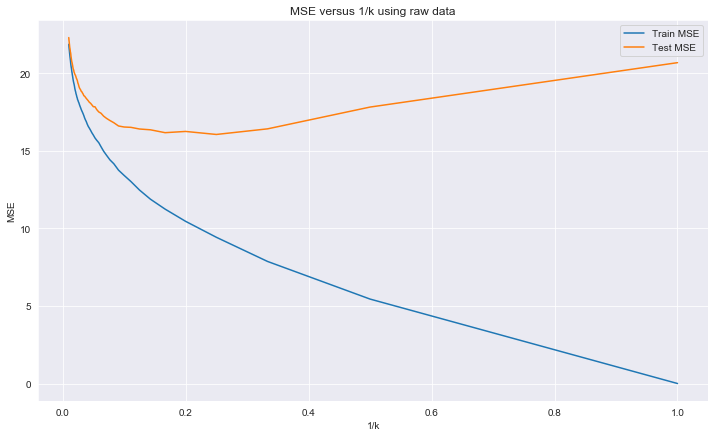

In [28]:
# plot error curves
fig, axes = plt.subplots(figsize=(12, 7))
axes.plot(k_reverse, train_error, label="Train MSE")
axes.plot(k_reverse, test_error, label="Test MSE")
axes.set_xlabel("1/k")
axes.set_ylabel("MSE")
axes.legend()
axes.set_title("MSE versus 1/k using raw data")
plt.show()

In [29]:
# use normalized data
from sklearn.preprocessing import normalize

norm_train_X_70 = normalize(train_X_70)
norm_test_X_30 = normalize(test_X_30)

k_reverse = []
train_error = []
test_error = []
min_idx = 0

for k in range(1, 101):
    # construct and fit the knn regressor
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(norm_train_X_70, train_Y_70)
    k_reverse.append(1 / k)
    # predict train set and calculate mse
    train_predict = knn.predict(norm_train_X_70)
    tmp_mse = mean_squared_error(train_Y_70, train_predict)
    train_error.append(tmp_mse)
    # predict test set and calculate mse
    test_predict = knn.predict(norm_test_X_30)
    tmp_mse = mean_squared_error(test_Y_30, test_predict)
    test_error.append(tmp_mse)
    # update the idx of minimum
    if tmp_mse < test_error[min_idx]:
        min_idx = k - 1;

mse_dict["normalized_KNN"] = [train_error[min_idx], test_error[min_idx]]
print("The best performance of KNN regressor with normalized data is:")
print("-" * 50)
print("k : {} \nTrain MSE: {} \nTest MSE : {}".format(round(1 / k_reverse[min_idx]), 
                                                      train_error[min_idx], 
                                                      test_error[min_idx]))

The best performance of KNN regressor with normalized data is:
--------------------------------------------------
k : 13 
Train MSE: 15.006301375134512 
Test MSE : 17.625370800156702


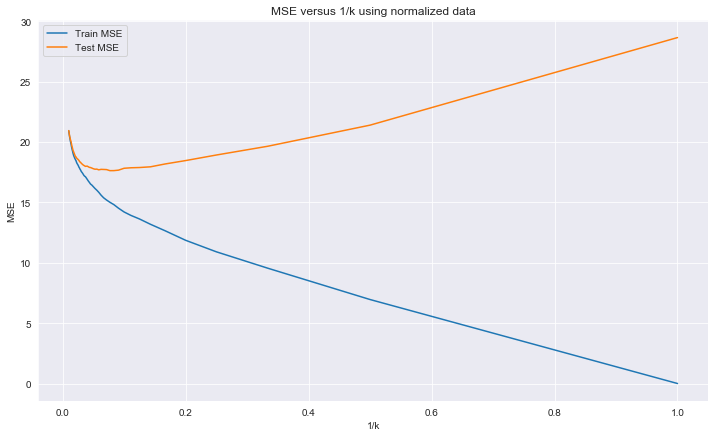

In [30]:
# plot error curves
fig, axes = plt.subplots(figsize=(12, 7))
axes.plot(k_reverse, train_error, label="Train MSE")
axes.plot(k_reverse, test_error, label="Test MSE")
axes.set_xlabel("1/k")
axes.set_ylabel("MSE")
axes.legend()
axes.set_title("MSE versus 1/k using normalized data")
plt.show()

In [31]:
# use standardized data

# following standarization is feasible as well
std_train_X_70 = train_X_70.apply(lambda col: (col-col.mean()) / np.std(col), axis = 0)
std_test_X_30 = test_X_30.apply(lambda col: (col-col.mean()) / np.std(col), axis = 0)

k_reverse = []
train_error = []
test_error = []
min_idx = 0

for k in range(1, 101):
    # construct and fit the knn regressor
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(std_train_X_70, train_Y_70)
    k_reverse.append(1 / k)
    # predict train set and calculate mse
    train_predict = knn.predict(std_train_X_70)
    tmp_mse = mean_squared_error(train_Y_70, train_predict)
    train_error.append(tmp_mse)
    # predict test set and calculate mse
    test_predict = knn.predict(std_test_X_30)
    tmp_mse = mean_squared_error(test_Y_30, test_predict)
    test_error.append(tmp_mse)
    # update the idx of minimum
    if tmp_mse < test_error[min_idx]:
        min_idx = k - 1;

mse_dict["standarized_KNN"] = [train_error[min_idx], test_error[min_idx]]
print("The best performance of KNN regressor with standarized data is:")
print("-" * 50)
print("k : {} \nTrain MSE: {} \nTest MSE : {}".format(round(1 / k_reverse[min_idx]), 
                                                      train_error[min_idx], 
                                                      test_error[min_idx]))

The best performance of KNN regressor with standarized data is:
--------------------------------------------------
k : 4 
Train MSE: 8.592742080658406 
Test MSE : 15.194751949041807


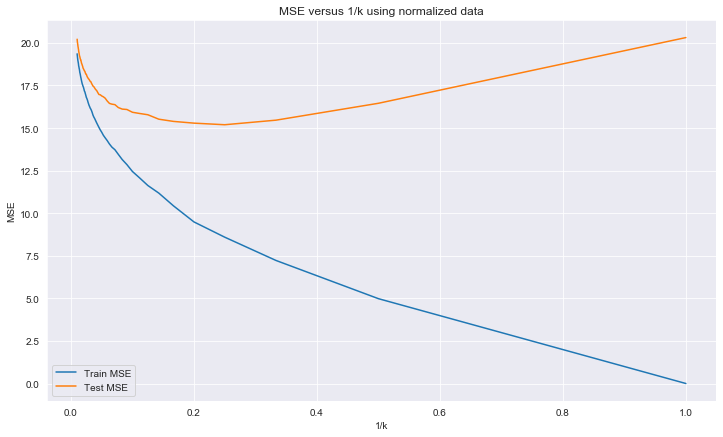

In [32]:
# plot error curves
fig, axes = plt.subplots(figsize=(12, 7))
axes.plot(k_reverse, train_error, label="Train MSE")
axes.plot(k_reverse, test_error, label="Test MSE")
axes.set_xlabel("1/k")
axes.set_ylabel("MSE")
axes.legend()
axes.set_title("MSE versus 1/k using normalized data")
plt.show()

## 1.(j) Compare the results of KNN Regression with the linear regression model

In [33]:
pd.DataFrame(mse_dict, index=["train_mse", "test_mse"])

,all_predictor_LR,all_inter_LR,improved_LR,raw_KNN,normalized_KNN,standarized_KNN
train_mse,20.518696,17.871294,17.876250,9.421980,15.006301,8.592742
test_mse,21.357070,18.677607,18.693091,16.046084,17.625371,15.194752


> For this dataset, KNN regressor seems to have a better performance according to the recorded MSE shown in table above. Although it's hard to show in a high-dimensional space, the possible reason of that is the data is difficult to linearly separate. The linear regression model will have give quite variant association results for each feature (p-values) with different data fro training. That implies the feature space is possibly more complex than a linear relationship. 

> Note that two different methods to preprocess data for KNN regressor are used. We can see an improvement and the same optimal K when using standarization (calculate z-score for features) while normalized data even performs worse than rwa data one and gives a very different optimal K.

# 2. ISLR: 2.4.1

For each of parts (a) through (d), indicate whether we would generally expect the performance of a flexible statistical learning method to be better or worse than an inflexible method. Justify your answer.

(a) The sample size n is extremely large, and the number of predic- tors p is small.

**Ans:** When the sample size goes extremely large, an inflexible method will suffers underfitting. Flexible will performs better than inflexible one for most case. 


(b) The number of predictors p is extremely large, and the number of observations n is small.

**Ans:** When the sample size is extremely large, a flexible method will possibly suffers overfitting. Thus, inflexible method will possibly better.


(c) The relationship between the predictors and response is highly non-linear.

**Ans:** An inflexible is hard to show the non-linear relationship. The flexible one will be better.


(d) The variance of the error terms, i.e. σ2 = Var(ε), is extremely high.

**Ans:** This case means our data suffers significant noise. That will mislead a flexible method and trap it into overfitting. Thus, inflexible method will be possibly better.



# 3. ISLR: 2.4.7

The table below provides a training data set containing six observa- tions, three predictors, and one qualitative response variable.

(a) Compute the Euclidean distance between each observation and thetestpoint,X1 =X2 =X3 =0.

In [34]:
from sklearn.metrics.pairwise import euclidean_distances
obs = [[0,3,0,'Red'],
       [2,0,0,'Red'],
       [0,1,3,'Red'],
       [0,1,2,'Green'],
       [-1,0,1,'Green'],
       [1,1,1,'Red']]

colordf = pd.DataFrame(obs, index=[1,2,3,4,5,6], columns=["X1", "X2", "X3", "Y"])
trainX = colordf.iloc[:, :-1].to_numpy()
trainY = colordf.iloc[:, -1].to_numpy()
testX = np.array([[0, 0, 0]])

dist = euclidean_distances(trainX, testX)

for i, d in enumerate(dist):
    print("The Euclidean distance between obs[{}] and the testpoint is {}".format(i, d[0]))

The Euclidean distance between obs[0] and the testpoint is 3.0
The Euclidean distance between obs[1] and the testpoint is 2.0
The Euclidean distance between obs[2] and the testpoint is 3.1622776601683795
The Euclidean distance between obs[3] and the testpoint is 2.23606797749979
The Euclidean distance between obs[4] and the testpoint is 1.4142135623730951
The Euclidean distance between obs[5] and the testpoint is 1.7320508075688772


(b) What is our prediction with K = 1? Why?

**Ans:** Choose the nearest one which is obs\[5\] Green


(c) What is our prediction with K = 3? Why?

**Ans:** Choose the nearest 3 and execute mojprity polling. The prediction should be Red.


(d) If the Bayes decision boundary in this problem is highly non-linear, then would we expect the best value for K to be large or small? Why?

**Ans:** A smaller value of K will works better when decision boundary is highly non-linear. A large K would try to fit a more linear boundary as it considers more points. 